# Landscape Evolution Modeling

A showcase of xarray-simlab in the context of landscape evolution modeling (an almost real world example).

In [1]:
import numpy as np
import xarray as xr
import xsimlab

## Import and inspect a model

The model (i.e., the `xsimlab.Model` object) that we use here is provided by the [xarray-topo](https://gitext.gfz-potsdam.de/sec55-public/xarray-topo) package.

In [2]:
from xtopo.models.fastscape_base import fastscape_base_model

This 2-dimensional model simulates the long-term evolution of topographic surface elevation, hereafter noted $h$. The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift $U$ (uniform in space and time) and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Erosion of bedrock river channels is given by the stream power law:

$$E = K A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

We can see these parameters - as well as the initial elevation surface and the grid parameters - as model inputs in the `repr`.

In [3]:
fastscape_base_model

<xsimlab.Model (9 processes, 13 inputs)>
grid
    x_length   (in) total grid length in x
    x_origin   (in) grid x-origin
    x_size     (in) nb. of nodes in x
    x_spacing  (in) node spacing in x
    y_length   (in) total grid length in y
    y_origin   (in) grid y-origin
    y_size     (in) nb. of nodes in y
    y_spacing  (in) node spacing in y
boundaries
uplift
    u_coef     (in) uplift rate
flow_routing
area
spower
    k_coef     (in) stream-power constant
    m_exp      (in) stream-power drainage area exponent
    n_exp      (in) stream-power slope exponent
erosion
exhumation
topography
    elevation  (in) topographic elevation

To have a better picture of all processes (and inputs and/or variables) in the model, we can visualize it as a graph. Processes are in blue and inputs are in yellow. The order in the graph corresponds to the order in which the processes will be exectued during a simulation.

Note: the visualization requires graphviz and python-graphviz packages (both can be installed using conda and the conda-forge channel).

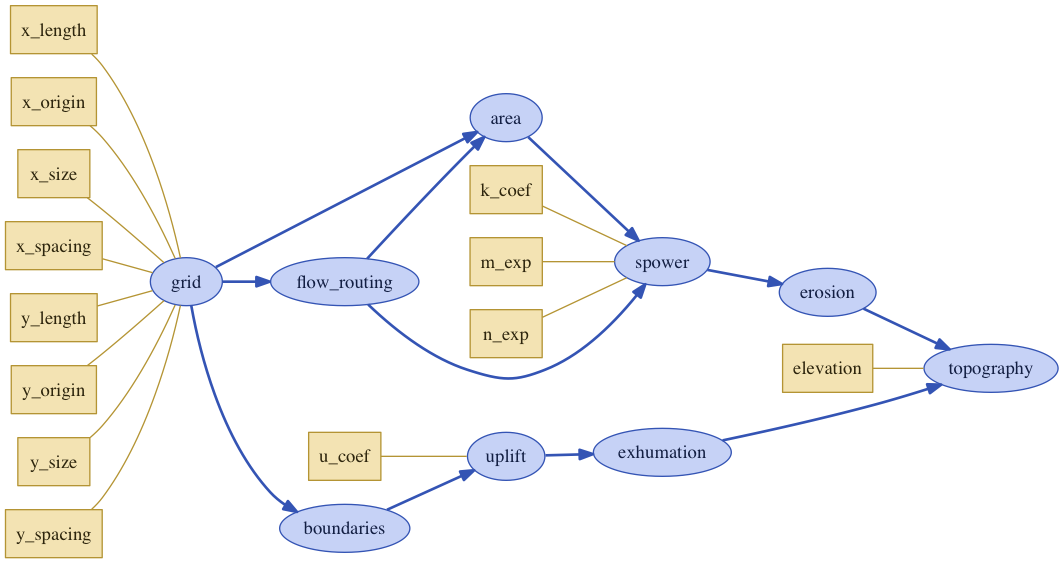

In [4]:
fastscape_base_model.visualize(show_inputs=True)

Note that in this model the 2-dimensional grid is actually stacked on the 'node' dimension, as shown below for the `x` and `y` variables. This is required by some of the algorithms implemented in the model.

In [5]:
fastscape_base_model.grid

<xsimlab.Process 'xtopo.models.fastscape_base.StackedGridXY'>
Variables:
  * x          Variable ('node')
    x_length   FloatVariable ()
    x_origin   FloatVariable ()
    x_size     IntegerVariable ()
    x_spacing  FloatVariable ()
  * y          Variable ('node')
    y_length   FloatVariable ()
    y_origin   FloatVariable ()
    y_size     IntegerVariable ()
    y_spacing  FloatVariable ()
Meta:
    time_dependent: False

## Create a model setup

We create a simulation setup using the `create_setup` function.

In [6]:
nx = 101
ny = 101

in_ds = xsimlab.create_setup(
    model=fastscape_base_model,
    clocks={
        'time': {'end': 1e6, 'step': 1e3},
        'out': {'end': 1e6, 'step': 1e5}
    },
    master_clock='time',
    input_vars={
        'grid': {'x_size': nx, 'y_size': ny, 'x_length': 1e5, 'y_length' :1e5},
        'topography': {'elevation': ('node', np.random.rand(nx * ny))},
        'spower': {'k_coef': 7e-5, 'm_exp': 0.4, 'n_exp': 1},
        'uplift': {'u_coef': 2e-3}
    },
    snapshot_vars={
        'out': {'topography': 'elevation'},
        None: {'grid': ('x', 'y')}
    }
)

Some explanation about the arguments of `create_setup` and the values given above:

- we specify the model we want to use, here `fastscape_base_model`,
- we give some arguments in order to create clock coordinates (i.e., time coordinates),
- among these coordinates, we specify the master clock, i.e., the coordinate that will be used to
  set the time steps,
- we set values for model inputs, grouped by process in the model,
- we set the model variables for which we want to take snapshots during a simulation, grouped first
  by clock coordinate (`None` means that only one snapshot will be taken at the end of the simulation)
  and then by process.
  
Here above, we define a 'time' coordinate and another coordinate 'out' with much larger but aligned
time steps (the values are in years). 'time' will be used for the simulation time steps and 'out' will be used to take just a few, evenly-spaced snapshots of
variable 'elevation' in process 'topography'. We also want to
save the $x$ and $y$ coordinates of the grid (values in meters), which are time-invariant.

The initial conditions consist here of a nearly flat topographic surface with small random perturbations.

`create_setup` returns a `xarray.Dataset` object that contains everything we need to run the simulation. 

In [7]:
in_ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_length         float64 1e+05
    grid__x_origin         float64 0.0
    grid__x_size           int64 101
    grid__x_spacing        float64 1e+03
    grid__y_length         float64 1e+05
    grid__y_origin         float64 0.0
    grid__y_size           int64 101
    grid__y_spacing        float64 1e+03
    topography__elevation  (node) float64 0.1485 0.6322 0.9068 0.0556 0.6836 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
Attributes:
    _xsimlab_snapshot_vars:  grid__x,grid__y

If present, the metadata (e.g., description, units, math_symbol...) associated to each input variable in the model are added as attributes in the dataset, e.g.,

In [8]:
in_ds.spower__k_coef

<xarray.DataArray 'spower__k_coef' ()>
array(7e-05)
Attributes:
    description:  stream-power constant

## Run the model

We run the model simply by calling `in_ds.xsimlab.run()`, which returns a new Dataset with both the inputs and the outputs. 

In [9]:
out_ds = in_ds.xsimlab.run(model=fastscape_base_model)

out_ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_length         float64 1e+05
    grid__x_origin         float64 0.0
    grid__x_size           int64 101
    grid__x_spacing        float64 1e+03
    grid__y_length         float64 1e+05
    grid__y_origin         float64 0.0
    grid__y_size           int64 101
    grid__y_spacing        float64 1e+03
    topography__elevation  (out, node) float64 0.1485 0.6322 0.9068 0.0556 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    grid__x                (node) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
    grid__y                (node) float64 0.0 0.0 0.0 0.0 0.0 0.0

Note in `out_ds` the `topography__elevation` variable which has now an additional `out` dimension and also the new variables `grid__x` and `grid__y`.

## Analyse, plot and save the results

The simulation input and output data is already in a format that allows us using all the nice features of xarray to further analyse, process, plot and/or write to disk (e.g., in a netCDF file) the data.

In this case for example, before doing any further processing it is more convenient to unstack the data back into the two spatial dimensions using xarray's `set_index` and `unstack` methods. We can easily chain these methods with `xsimlab.run` as they all return Dataset objects: 

In [10]:
out_ds = (in_ds
          .xsimlab.run(model=fastscape_base_model)
          .set_index(node=['grid__x', 'grid__y'])
          .unstack('node'))

The resulting Dataset has no more `node` dimension but has `grid__x` and `grid__y` dimensions instead.  

In [11]:
out_ds

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
Data variables:
    grid__x_length         float64 1e+05
    grid__x_origin         float64 0.0
    grid__x_size           int64 101
    grid__x_spacing        float64 1e+03
    grid__y_length         float64 1e+05
    grid__y_origin         float64 0.0
    grid__y_size           int64 101
    grid__y_spacing        float64 1e+03
    topography__elevation  (out, grid__x, grid__y) float64 0.1485 0.789 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002

It is then easier to plot the simulation outputs, e.g., here below the elevation values at the end of the simulation:

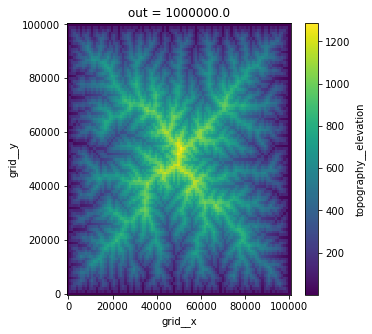

In [12]:
%matplotlib inline

xr.plot.pcolormesh(out_ds.isel(out=-1).topography__elevation.T,
                   size=5, aspect=1);

xarray datasets can be used with [Holoview](http://holoviews.org/), a plotting package that is really helpful for quickly and interactively exploring multi-dimensional data. (it can be installed using conda).

In [29]:
import holoviews as hv

hv.notebook_extension('matplotlib')

We can for example see below how the relief is created during the simulation (snapshots are taken every 100000 years and elevation values are in meters).

**Note:** There may be issues with rendering Holoview interactive visualizations if you are on xarray-simlab's documentation. Fortunately you should be able to see this page as a notebook properly rendered on [nbviewer.org](http://nbviewer.jupyter.org/github/benbovy/xarray-simlab/blob/master/doc/examples/landscape-evolution-model.ipynb).

:HoloMap   [out]
   :Image   [grid__x,grid__y]   (topography__elevation)
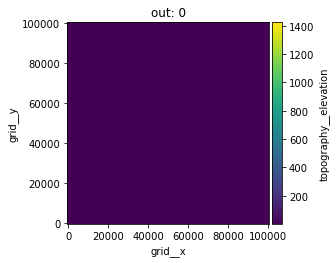
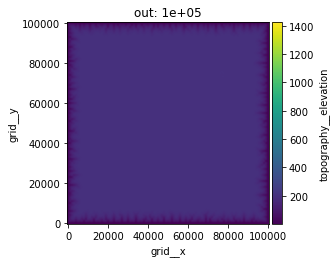
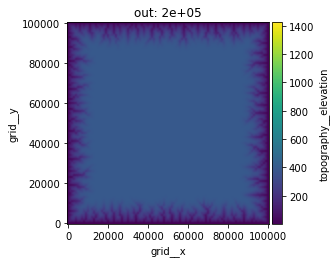
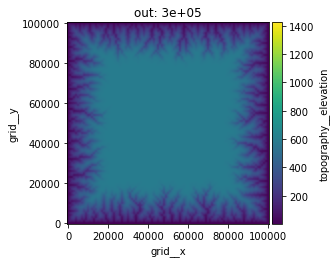
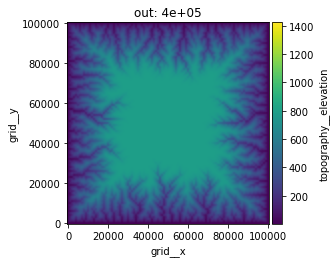
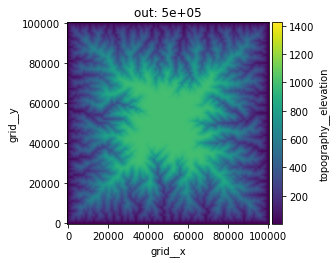
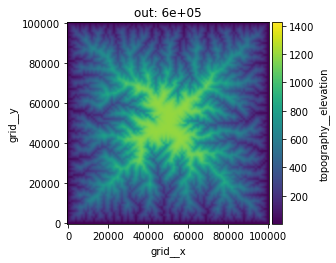
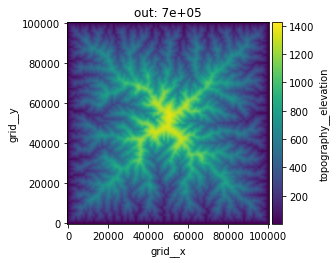
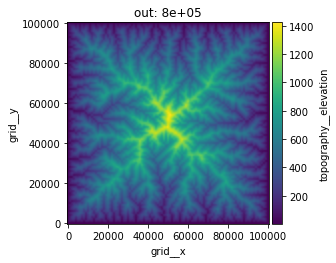
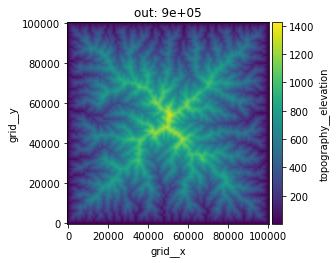
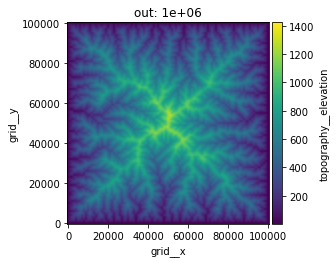

In [14]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])

Additionally, We can compute derived quantities without much effort. Here below we calculate the surface denudation rates (in m/yr) averaged over each time steps of the output `out` dimension. 

In [15]:
def denudation_rate(ds, time_dim='out'):
    topo = ds.topography__elevation
    dt = ds[time_dim].diff(time_dim)
    den_rate = topo.diff(time_dim) / dt - ds.uplift__u_coef
    return den_rate

In [16]:
den_rate = denudation_rate(out_ds)

We further compute and plot the spatially averaged denudation rate.

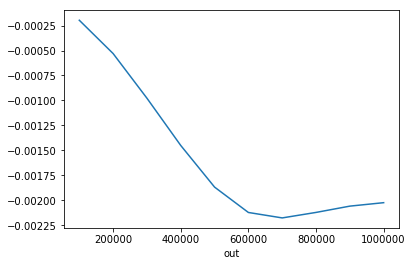

In [17]:
den_rate.mean(('grid__x', 'grid__y')).plot();

## Run the model with time-varying parameter values

Instead of providing constant, scalar values for model inputs, it is possible to provide arrays which have the same dimension as the one used for the "master clock" (the `time` dimension in this case).

As an example, we try below a sinusoidal variation for the $K$ parameter of the stream power law, with a period of 400000 years.

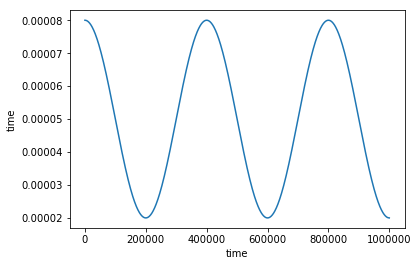

In [18]:
da_k_time = 5e-5 + 3e-5 * np.cos((2 * np.pi / 4e5) * in_ds.time)

da_k_time.plot();

We then re-use the simulation setup created above and only update the parameters of the stream-power process with the new values for $K$ (using `Dataset.xsimlab.update_vars`).

Note the `time` dimension of the `spower__k_coef` variable in the new returned Dataset.

In [19]:
in_ds_kt = in_ds.xsimlab.update_vars(
    model=fastscape_base_model,
    input_vars={'spower': {'k_coef': da_k_time, 'm_exp': 0.4, 'n_exp': 1}}
)

in_ds_kt

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_length         float64 1e+05
    grid__x_origin         float64 0.0
    grid__x_size           int64 101
    grid__x_spacing        float64 1e+03
    grid__y_length         float64 1e+05
    grid__y_origin         float64 0.0
    grid__y_size           int64 101
    grid__y_spacing        float64 1e+03
    topography__elevation  (node) float64 0.1485 0.6322 0.9068 0.0556 0.6836 ...
    spower__k_coef         (time) float64 8e-05 8e-05 7.999e-05 7.997e-05 ...
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
Attributes:
    _xsimlab_snapshot_vars:  grid__x,grid__y

We then run the model, unstack the spatial dimensions, compute the denudation rates and plot the spatial averages, here again by easily chaining xarray and xarray-simlab methods on the input Dataset.

If we compare the results with those from the previous run, we clearly see the impact of the time-varying $K$ parameter values on the denudation rates. 

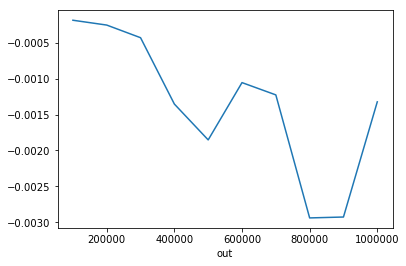

In [20]:
den_rate_kt = (in_ds_kt
               .xsimlab.run(model=fastscape_base_model)
               .set_index(node=['grid__x', 'grid__y'])
               .unstack('node')
               .pipe(denudation_rate))

den_rate_kt.mean(('grid__x', 'grid__y')).plot();

## Run and combine different model setups

Here is an brief example of running the model multiple times for different fixed values of $K$ and then concatenate the results into a single dataset. In next versions of xarray-simlab, this process will be even simpler.

In [21]:
def run_model(k_value):
    print('run k=%f' % k_value)
    
    ivars = {'spower': {'k_coef': k_value, 'm_exp': 0.4, 'n_exp': 1}}
    
    out_ds = (in_ds
              .xsimlab.update_vars(model=fastscape_base_model,
                                   input_vars=ivars)
              .xsimlab.run(model=fastscape_base_model)
              .set_index(node=['grid__x', 'grid__y'])
              .unstack('node'))
    
    return out_ds

 
out_ds_multi = xr.concat(
    [run_model(k) for k in (5e-5, 6e-5, 7e-5)],
    dim='spower__k_coef', data_vars='different'
)

run k=0.000050
run k=0.000060
run k=0.000070


Note the additional `spower__k_coef` dimension, which has its own coordinate with labels corresponding to the different $K$ values.

In [22]:
out_ds_multi

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, spower__k_coef: 3, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * spower__k_coef         (spower__k_coef) float64 5e-05 6e-05 7e-05
Data variables:
    grid__x_length         float64 1e+05
    grid__x_origin         float64 0.0
    grid__x_size           int64 101
    grid__x_spacing        float64 1e+03
    grid__y_length         float64 1e+05
    grid__y_origin         float64 0.0
    grid__y_size           int64 101
    grid__y_spacing        float64 1e+03
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    topography__elevation  (spower__k_coef, 

This new dimension also appears in the Holoview figure

:HoloMap   [out,spower__k_coef]
   :Image   [grid__x,grid__y]   (topography__elevation)
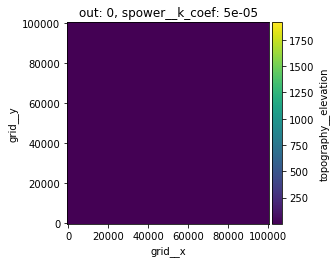
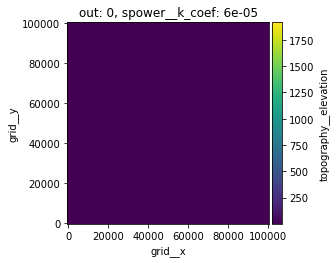
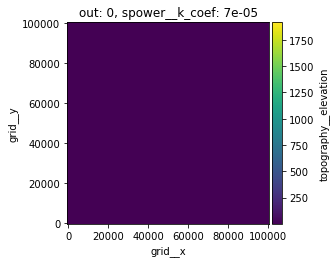
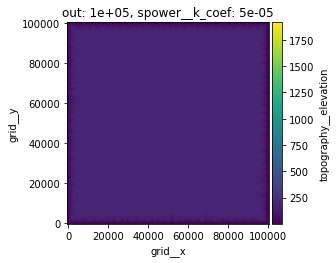
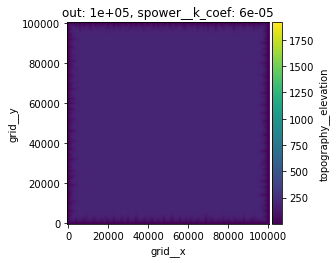
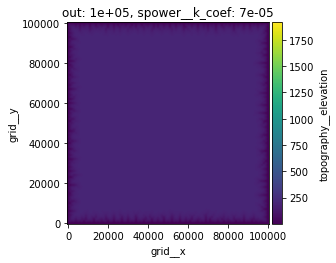
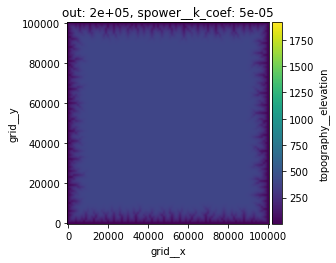
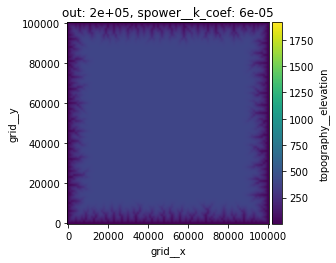
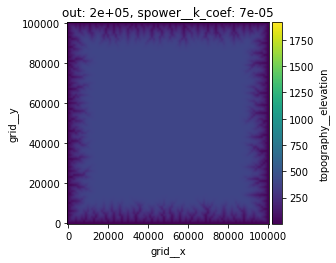
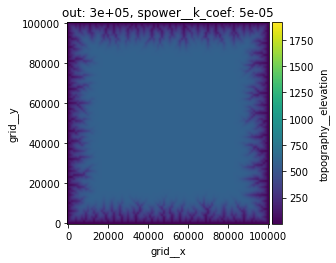
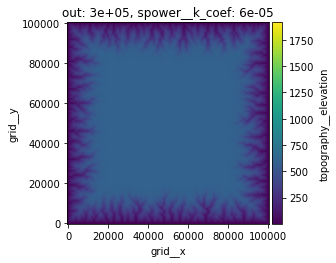
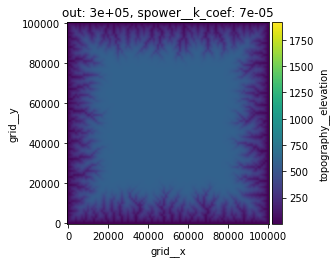
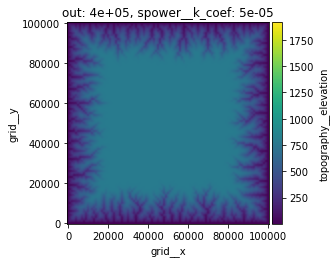
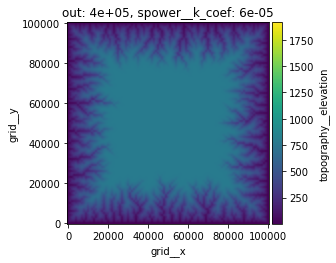
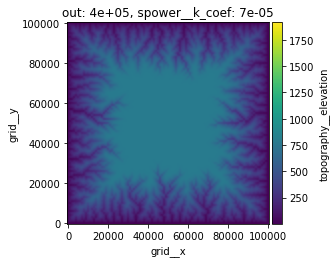
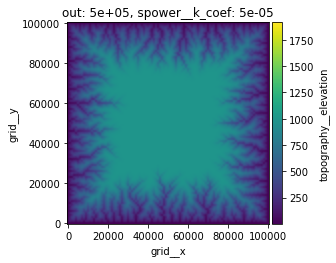
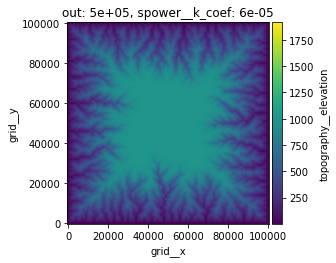
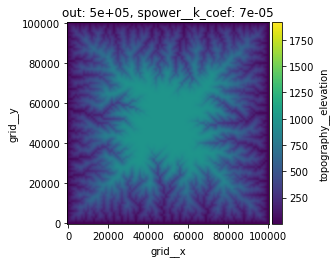
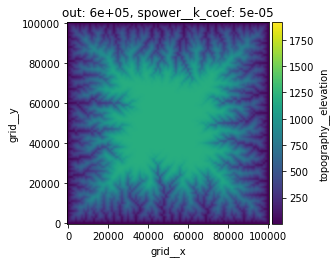
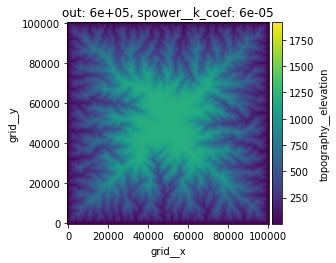
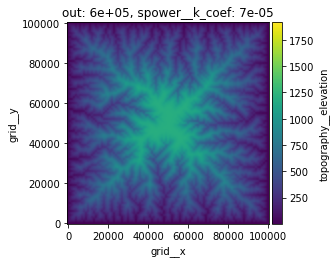
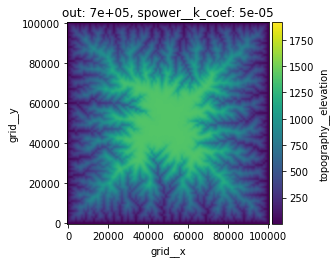
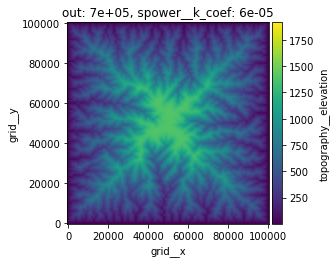
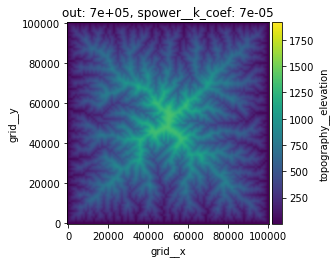
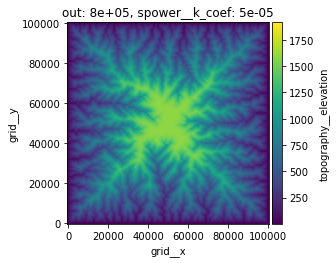
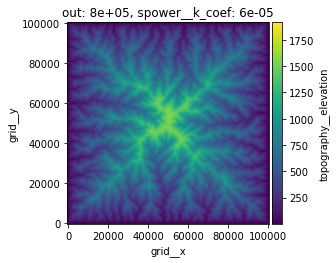
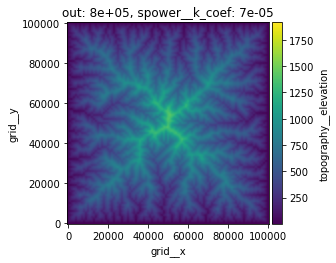
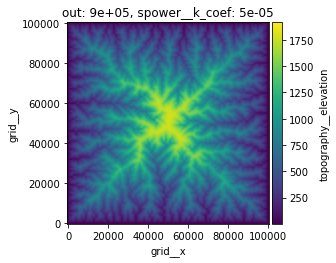
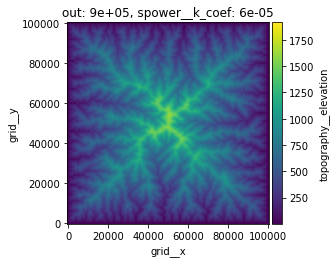
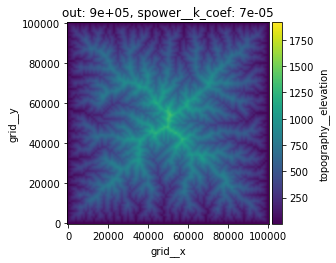
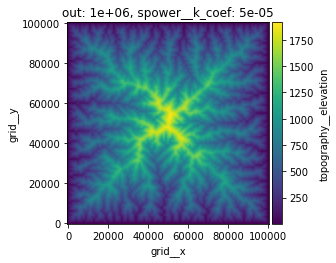
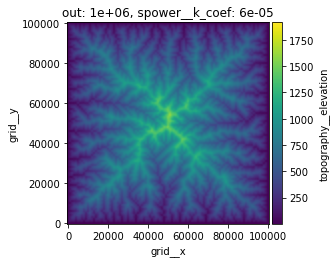
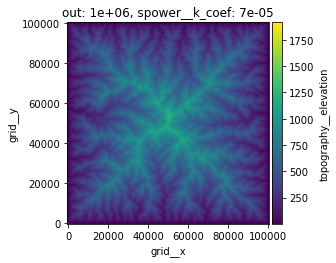

In [23]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_multi.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])

## Create an alternative version of the model

xarray-simlab makes it easy to create alternative versions of a model. In the example below, instead of using constant block uplift, we set a linear uplift function along the $x$ dimension. The first step is to create a new `Process` class. 

In [24]:
from xtopo.models.fastscape_base import StackedGridXY, BoundaryFacesXY
from xsimlab import Process, FloatVariable, Variable, ForeignVariable


class VariableUplift(xsimlab.Process):
    """Compute spatially variable uplift as a linear function of x."""
    
    x_coef = FloatVariable((), description='uplift function x coefficient')
    active_nodes = ForeignVariable(BoundaryFacesXY, 'active_nodes')
    x = ForeignVariable(StackedGridXY, 'x')
    uplift = Variable((), provided=True, group='exhumation')

    def initialize(self):
        mask = self.active_nodes.value
        u_rate = self.x_coef.value * self.x.value
        
        self.uplift.rate = np.zeros_like(self.x.value)
        self.uplift.rate[mask] = u_rate[mask]

    def run_step(self, dt):
        self.uplift.change = self.uplift.rate * dt


We then update the model that we used above with the new process (note the change in repr: the `uplift` process has now an `x_coef` input).

In [25]:
alt_model = fastscape_base_model.update_processes({'uplift': VariableUplift})

alt_model

<xsimlab.Model (9 processes, 13 inputs)>
grid
    x_length   (in) total grid length in x
    x_origin   (in) grid x-origin
    x_size     (in) nb. of nodes in x
    x_spacing  (in) node spacing in x
    y_length   (in) total grid length in y
    y_origin   (in) grid y-origin
    y_size     (in) nb. of nodes in y
    y_spacing  (in) node spacing in y
boundaries
uplift
    x_coef     (in) uplift function x coefficient
flow_routing
area
spower
    k_coef     (in) stream-power constant
    m_exp      (in) stream-power drainage area exponent
    n_exp      (in) stream-power slope exponent
erosion
exhumation
topography
    elevation  (in) topographic elevation

We then re-use our intial setup, remove from this setup everything that is not related to the new model (using `Dataset.xsimlab.filter_vars` which here drops the `uplift__u_coef` variable), update the setup with the new parameter and then run the model.

Note that in some cases it is convenient to use the `with` statement with a `Model` object. For example we don't need to provide the `model` argument in `filter_vars`, `update_vars` and `run` methods below. 

In [26]:
with alt_model:
    out_ds_alt = (
        in_ds
        .xsimlab.filter_vars()
        .xsimlab.update_vars(input_vars={'uplift': {'x_coef': 1e-7}})
        .xsimlab.run()
        .set_index(node=['grid__x', 'grid__y'])
        .unstack('node')
    )

You can compare the results obtained here with the results obtained above.

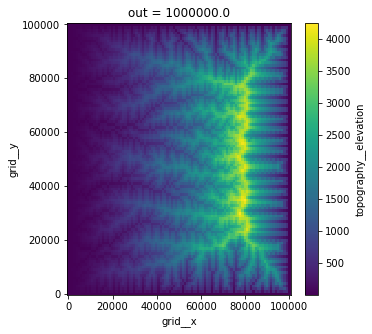

In [27]:
xr.plot.pcolormesh(out_ds_alt.isel(out=-1).topography__elevation.T,
                   size=5, aspect=1);

:HoloMap   [out]
   :Image   [grid__x,grid__y]   (topography__elevation)
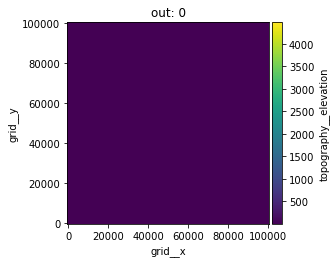
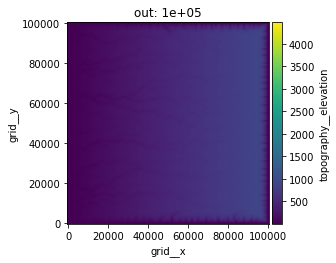
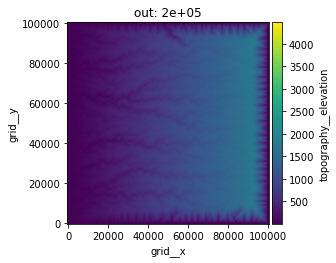
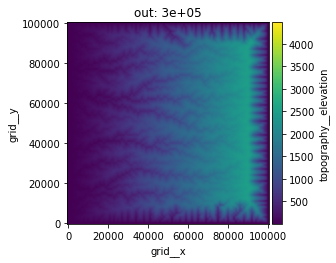
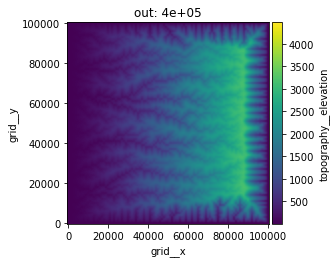
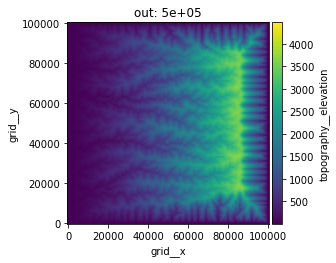
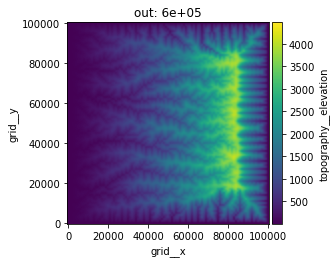
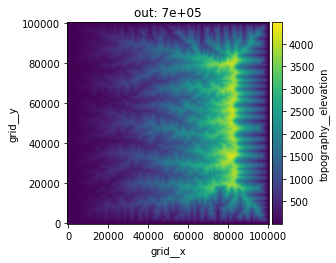
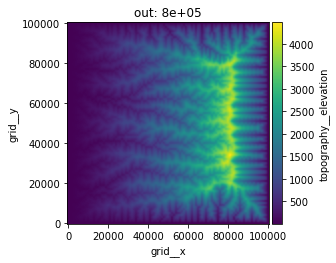
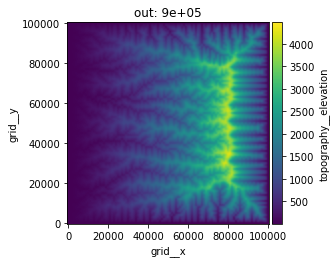
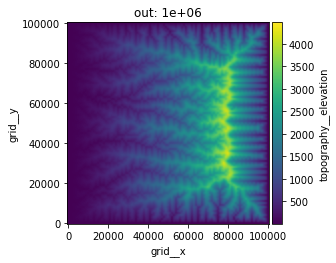

In [28]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_alt.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])